In [1]:
!pip install NetworkX

from networkx.generators.random_graphs import gnp_random_graph
from networkx.drawing.nx_pylab import draw

##Part 1

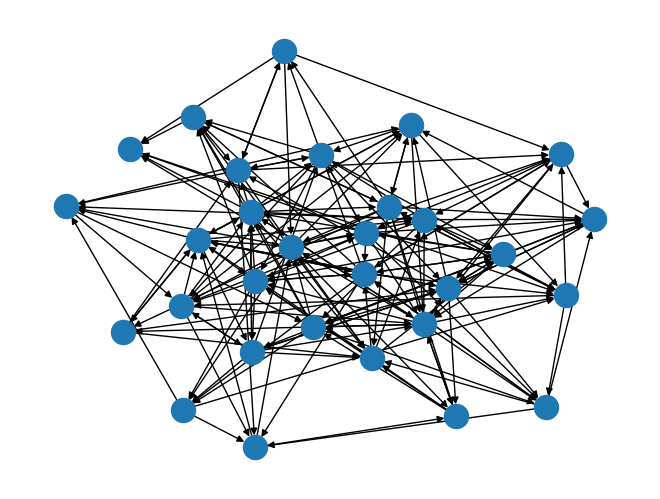

In [2]:
graph = gnp_random_graph( n=30, p=0.2, seed=5, directed=True)
draw(graph)

In [5]:
import numpy as np

def pagerank(graph, alpha, tolerance = 1e-3):
  # initializing an adjacency list
  adj = np.array([[0]*30 for _ in graph.nodes], dtype=float)

  # creating adjacency list based on the digraph
  for (node, to) in graph.edges:
    adj[node][to] = 1

  # Normalize values using row sums (turning values to probability)
  row_sums = adj.sum(axis=1, keepdims=True)  # Sum along rows, keep dimensions
  adj = np.divide(adj, row_sums, out=np.zeros_like(adj), where=row_sums!=0)
  # Divide by row sums, handle zero sums

  # Applying damping factor and normalizing
  adj = alpha*adj + (1-alpha)*np.ones(adj.shape)/30
  row_sums = adj.sum(axis=1, keepdims=True)
  adj = np.divide(adj, row_sums, out=np.zeros_like(adj), where=row_sums!=0)

  while (np.sum(np.square(adj.T@adj-adj)) < tolerance):
    adj = adj.T@adj

  final = adj.sum(axis = 0, keepdims = True)
  # rank = np.argsort(final)[::-1]
  final = final/np.sum(final)
  final = final.tolist()[0]
  def create_dictionary(values):
    keys = list(range(1, len(values) + 1))  # Create keys starting from 1
    my_dict = dict(zip(keys, values))  # Create dictionary using zip
    return my_dict
  dic = create_dictionary(final)
  return dic


In [6]:
my_rank = pagerank(graph, alpha = 0.85, tolerance = 1e-3)

In [7]:
import networkx as nx

pagerank_scores = nx.pagerank(graph, alpha=0.9, max_iter=200)

def list_dic(my_dict):
  values_list = [my_dict[key] for key in sorted(my_dict.keys())]
  return values_list

np.corrcoef(list_dic(pagerank_scores), list_dic(my_rank))[0][1]


0.9244084008355697

It seems networkx pagerank and my function output are highly corrolated.

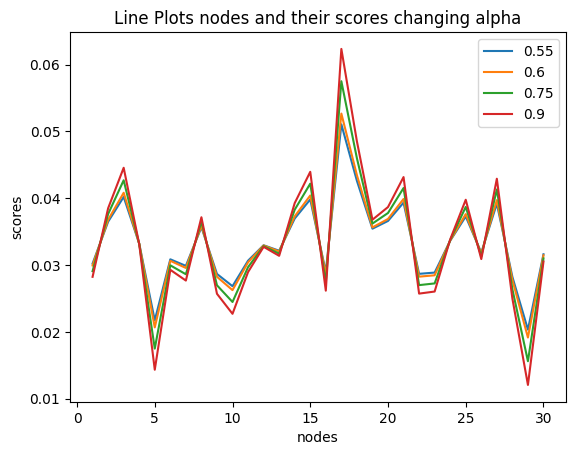

In [8]:
import matplotlib.pyplot as plt

dict_list = [pagerank(graph, alpha ) for alpha in (0.55, 0.6, 0.75, 0.9)]

def plot_multiple_dictionaries(dict_list, labels=None):
  fig, ax = plt.subplots()

  for i, data_dict in enumerate(dict_list):
    x_values = list(data_dict.keys())
    y_values = list(data_dict.values())

    label = labels[i] if labels else None
    ax.plot(x_values, y_values, label=label)

  ax.set_xlabel("nodes")
  ax.set_ylabel("scores")
  ax.set_title("Line Plots nodes and their scores changing alpha")

  if labels:
    ax.legend()

  plt.show()

plot_multiple_dictionaries(dict_list, (0.55, 0.6, 0.75, 0.9))

It looks like with a higher damping factor nodes with scores higher that median score ( popular nodes ) have higher scores and less popular nodes have a lower score. In other word increasing damping factor increases variability of scores. In some sense the higher the damping factor, the scores are higher for poular nodes and lower for less popular nodes.

Tolerance in networkx has a subtle difference comparing to my algorithm. networkx also uses an optional personalization factor that manipulates the adjacency list matrix considering some user's personalization adding personalization weights to adjacency list in the same way my function adds teleport with a coefficient.

One other major difference between two algorithms is that networkx accepts an optional dictionary called dangling that assigns arbitrary edges to the nodes that have no outedges which cause spider trap problems so so that they do not end up with a score of one. I think the best way to choose that edge is that it should point to a node with the least number of in-degree edges (to avoid spider trap).

##Part 2

In [16]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [25]:
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

batch_size =4
mnist_train = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

mnist_test = datasets.MNIST(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [26]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.312
[1,  4000] loss: 0.148
[1,  6000] loss: 0.116
[1,  8000] loss: 0.096
[1, 10000] loss: 0.099
[1, 12000] loss: 0.085
[1, 14000] loss: 0.072
[2,  2000] loss: 0.072
[2,  4000] loss: 0.070
[2,  6000] loss: 0.068
[2,  8000] loss: 0.068
[2, 10000] loss: 0.073
[2, 12000] loss: 0.067
[2, 14000] loss: 0.072
Finished Training


In [27]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

Accuracy of the network on test images: 98 %
